## 1. Why do we need RAG (Retrieval Augmented Generation)?

* Avoid the halluciation of the LLM model by:
    * Providing external data (our data source may not provide enough context to the model)
    * Plug-in domain-knowledge base to generate context-aware answer
* Avoid retraining the whole model, just need to update the external knowledge base
* Pipeline:
    * Data source --> database --> chunking and embedding --> vector db --> provide relevant data to LLM model.
    * Inside the vector db, we perform similarity search

## 2. Agents (https://www.ibm.com/think/topics/ai-agents-vs-ai-assistants#7281536)

* An AI agent refers to a system or program that can autonomously complete tasks on behalf of users or another system by designing its own workflow and by using available tools.

* AI agents can encompass a wide range of functions beyond NLP. These include decision-making, problem-solving, interacting with external environments and executing actions. 

## 3. Creating Tools

In [17]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun 
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [18]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper,description="Query Arxiv Papers")
print(arxiv.name)

arxiv


In [19]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [20]:
arxiv.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogr'

In [21]:
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
wiki.name

'wikipedia'

In [22]:
import os 
import dotenv 
from dotenv import load_dotenv 

load_dotenv()

True

In [23]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults 

tavily = TavilySearchResults()

In [25]:
tavily.invoke("Provide recent AI research")

[{'title': 'The 2025 AI Index Report | Stanford HAI',
  'url': 'https://hai.stanford.edu/ai-index/2025-ai-index-report',
  'content': 'In 2023, researchers introduced new benchmarks—MMMU, GPQA, and SWE-bench—to test the limits of advanced AI systems. Just a year later, performance sharply increased: scores rose by 18.8, 48.9, and 67.3 percentage points on MMMU, GPQA, and SWE-bench, respectively. Beyond benchmarks, AI systems made major strides in generating high-quality video, and in some settings, language model agents even outperformed humans in programming tasks with limited time budgets. [...] ### 2. AI is increasingly embedded in everyday life.\n\nFrom healthcare to transportation, AI is rapidly moving from the lab to daily life. In 2023, the FDA approved 223 AI-enabled medical devices, up from just six in 2015. On the roads, self-driving cars are no longer experimental: Waymo, one of the largest U.S. operators, provides over 150,000 autonomous rides each week, while Baidu’s affor

#### 3.1 Combining tools in the list

In [26]:
tools = [arxiv,wiki,tavily]

In [29]:
## Initialize LLM models

from langchain_groq import ChatGroq 

llm_model = ChatGroq(model="qwen/qwen3-32b")

In [30]:
llm_model.invoke("What is AI?")

AIMessage(content='<think>\nOkay, the user asked me, "What is AI?" First, I need to figure out what they\'re really asking for. They might be a student starting to learn about AI or someone who hears the term often but isn\'t sure what it means. I should start with a basic definition, maybe mention machine learning and neural networks.\n\nWait, should I include the history? Like when AI was first introduced in the 1950s? That could give context. Also, the different types of AI—narrow vs. general. Maybe explain the difference because people often confuse AI with human-like intelligence.\n\nExamples would help. Like how AI is used in everyday applications: voice assistants, recommendation systems, self-driving cars. That makes it more relatable. Also, mention some key techniques such as deep learning and natural language processing. But I should avoid getting too technical unless they ask for more details.\n\nI should also touch on the current state of AI. It\'s mostly Narrow AI right no

In [31]:
model_with_tools = llm_model.bind_tools(tools=tools)

In [33]:
# Execute 
model_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. I need to figure out which tool to use here. Let me check the available tools. There\'s Tavily Search, which is optimized for current events. That sounds right because the user wants the latest news. Arxiv is for academic papers, and Wikipedia is for general knowledge, but not the most recent events. So I should use Tavily Search. The query parameter should be "recent news on AI". Let me structure the tool call accordingly.\n', 'tool_calls': [{'id': 'kyvsjqnsn', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 354, 'total_tokens': 489, 'completion_time': 0.247472063, 'prompt_time': 0.126999144, 'queue_time': 0.230220665, 'total_time': 0.374471207}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_ti

## 4. Workflow

* Start [Prompt] --> AI assistant and Tools  --> End

In [ ]:
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage      #Human message or AI message
from typing import Annotated                        # Labelling
from langgraph.graph.message import add_messages   # Reducers in Langgraph

In [52]:
# Define state schema

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [53]:
## Entire chatbot with LangGraph
from IPython.display import Image, display 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

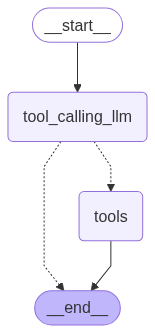

In [54]:
# Define Node
def tool_calling_llm(state: State):
    return {"messages": model_with_tools.invoke(state["messages"])}

# Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
from langchain.schema import HumanMessage, AIMessage, SystemMessage

result = graph.invoke({"messages": [HumanMessage(content="1706.03762")]})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (05dfta24f)
 Call ID: 05dfta24f
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [58]:
result = graph.invoke({"messages": "Hi, my name is An"})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is An
================================== Ai Message ==================================

Hello An! How can I assist you today?
